#Google Drive Bağlantısı

In [1]:
from google.colab import drive
import os

# Google Drive'ı mount et
drive.mount('/content/drive')

# Görüntü ve etiketlerin yollarını belirle
image_dir = "/content/drive/My Drive/BeyinInmeVerisi/images2"
label_dir = "/content/drive/My Drive/BeyinInmeVerisi/masks"

# Görsellerin ve labellerin listesi
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')])
label_paths = sorted([os.path.join(label_dir, fname) for fname in os.listdir(label_dir) if fname.endswith('.png')])


Mounted at /content/drive


#Görsellerin Yükleme ve İşleme İşlemleri

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Görselleri yükleyip işleyelim
def load_and_preprocess_images(image_paths, label_paths, img_size=(512, 512)):
    images = []
    labels = []

    for img_path, lbl_path in zip(image_paths, label_paths):
        # Görseli yükle
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)  # Görüntüyü yeniden boyutlandır
        img = img / 255.0  # Normalizasyon

        # Labeli yükle
        lbl = cv2.imread(lbl_path, cv2.IMREAD_GRAYSCALE)
        lbl = cv2.resize(lbl, img_size)
        lbl = np.where(lbl > 127, 1, 0)  # Binary maske

        images.append(img)
        labels.append(lbl)

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)  # Kanal boyutu ekle
    labels = np.array(labels).reshape(-1, img_size[0], img_size[1], 1)
    return images, labels

# Görselleri ve labelleri yükle
img_size = (256, 256)
X, Y = load_and_preprocess_images(image_paths, label_paths, img_size)

# Eğitim ve doğrulama setine ayır
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


#Model Tanımlama

In [ ]:
from tensorflow.keras import layers, Model

def unet_model(input_shape=(256, 256, 1)):
    inputs = layers.Input(input_shape)

    # Encoder (Downsampling Path)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (Upsampling Path)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


Derleme ve Model Özeti

In [ ]:
model = unet_model(input_shape=(img_size[0], img_size[1], 1))

# Modeli derle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model özetini inceleyin
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

Model Eğitimi

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=16,
    verbose=1
)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 175s 6s/step - accuracy: 0.9916 - loss: 0.3241 - val_accuracy: 0.9916 - val_loss: 0.0444
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 813ms/step - accuracy: 0.9921 - loss: 0.0413 - val_accuracy: 0.9916 - val_loss: 0.0364
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 803ms/step - accuracy: 0.9918 - loss: 0.0299 - val_accuracy: 0.9916 - val_loss: 0.0296
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 774ms/step - accuracy: 0.9919 - loss: 0.0262 - val_accuracy: 0.9916 - val_loss: 0.0281
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 796ms/step - accuracy: 0.9919 - loss: 0.0256 - val_accuracy: 0.9916 - val_loss: 0.0275
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 807ms/step - accuracy: 0.9921 - loss: 0.0243 - val_accuracy: 0.9916 - val_loss: 0.0263
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 774ms/step - accuracy: 0.9919 - loss: 0.0240 - val_accuracy: 0.9916 - val_loss: 0.0269
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 772ms/step - accuracy: 0.9918 - loss: 0.0241 - val_accura

Model Eğitimi 2

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Eğitim
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.9976 - loss: 0.0060
Epoch 1: val_loss improved from inf to 0.00853, saving model to best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 920ms/step - accuracy: 0.9976 - loss: 0.0060 - val_accuracy: 0.9967 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.9977 - loss: 0.0058
Epoch 2: val_loss did not improve from 0.00853
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 787ms/step - accuracy: 0.9977 - loss: 0.0058 - val_accuracy: 0.9960 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.9977 - loss: 0.0057
Epoch 3: val_loss improved from 0.00853 to 0.00758, saving model to best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 910ms/step - accuracy: 0.9977 - loss: 0.0057 - val_accuracy: 0.9971 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.9978 - loss: 0.0055
Epoch 4: val_loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


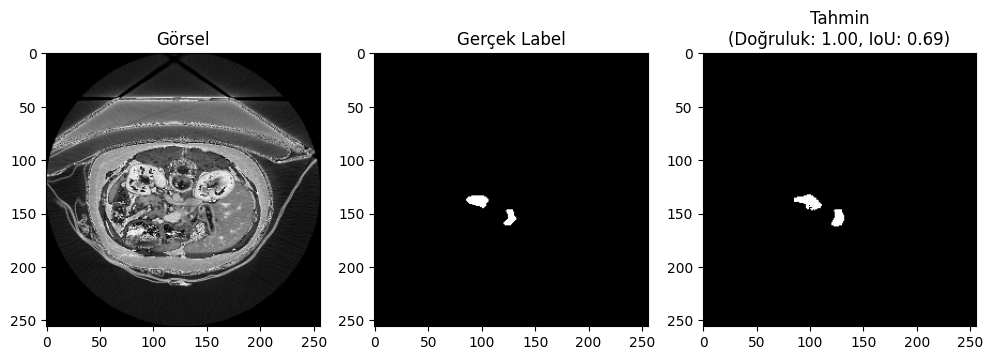

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


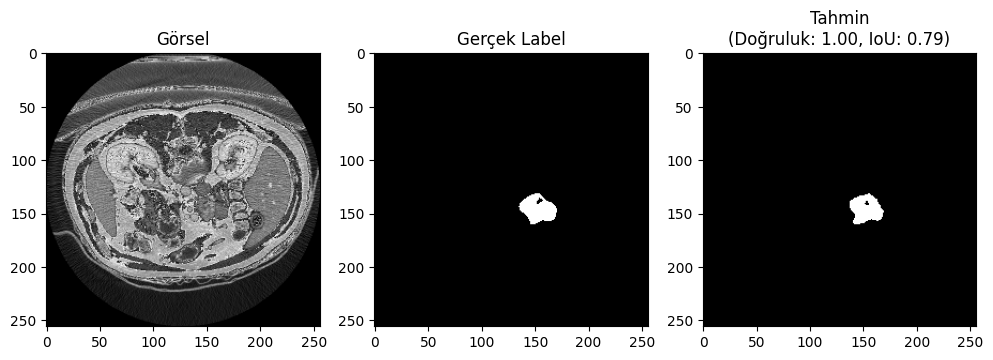

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


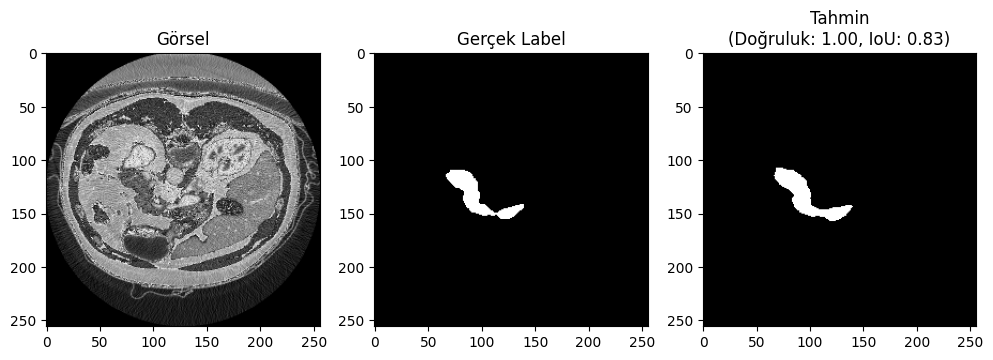

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# IoU hesaplama fonksiyonu
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    iou = intersection / union if union > 0 else 0.0
    return iou

# Görselleştirme, doğruluk ve IoU hesaplama
sample_idx = np.random.randint(0, len(X_val), 3)
for i in sample_idx:
    img = X_val[i]
    lbl = Y_val[i]

    # Model tahmini
    pred = model.predict(img[np.newaxis, ...])[0]
    pred = (pred > 0.5).astype(np.uint8)  # Eşikleme

    # Doğruluk skoru hesaplama
    lbl_flat = lbl.flatten()
    pred_flat = pred.flatten()
    acc = accuracy_score(lbl_flat, pred_flat)

    # IoU hesaplama
    iou = calculate_iou(lbl.squeeze(), pred.squeeze())

    # Görselleştirme
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Görsel")
    plt.imshow(img.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Gerçek Label")
    plt.imshow(lbl.squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title(f"Tahmin\n(Doğruluk: {acc:.2f}, IoU: {iou:.2f})")  # Doğruluk ve IoU başlıkta gösterilir
    plt.imshow(pred.squeeze(), cmap='gray')
    plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

# Doğruluk skorunu hesapla
def calculate_accuracy(model, X_val, Y_val, threshold=0.5):
    accuracies = []
    for i in range(len(X_val)):
        img = X_val[i]
        lbl = Y_val[i]

        # Modelin tahmini
        pred = model.predict(img[np.newaxis, ...])[0]
        pred = (pred > threshold).astype(np.uint8)  # Eşikleme

        # Gerçek maskeyi ve tahmini tek boyuta çevir (flatten) ve doğruluğu hesapla
        lbl_flat = lbl.flatten()
        pred_flat = pred.flatten()
        acc = accuracy_score(lbl_flat, pred_flat)
        accuracies.append(acc)

    # Ortalama doğruluk
    mean_accuracy = sum(accuracies) / len(accuracies)
    return mean_accuracy

# Doğruluk skorunu hesapla
accuracy = calculate_accuracy(model, X_val, Y_val)
print(f"Doğruluk Skoru: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

Model Kaydı

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


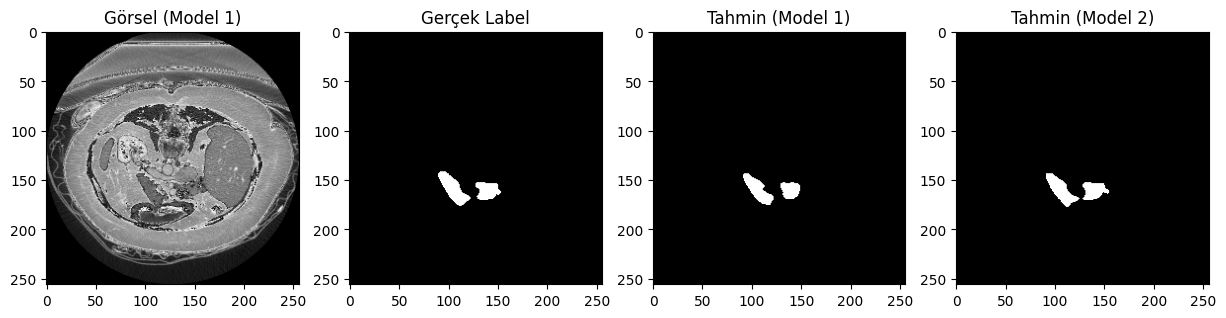

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


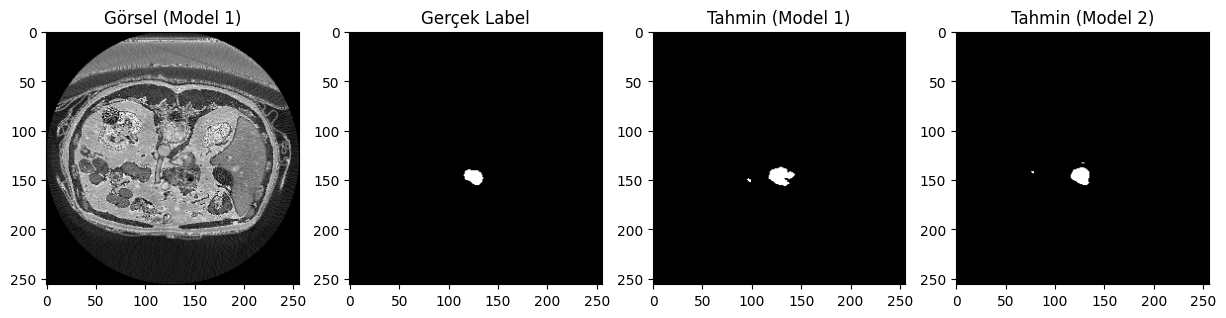

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


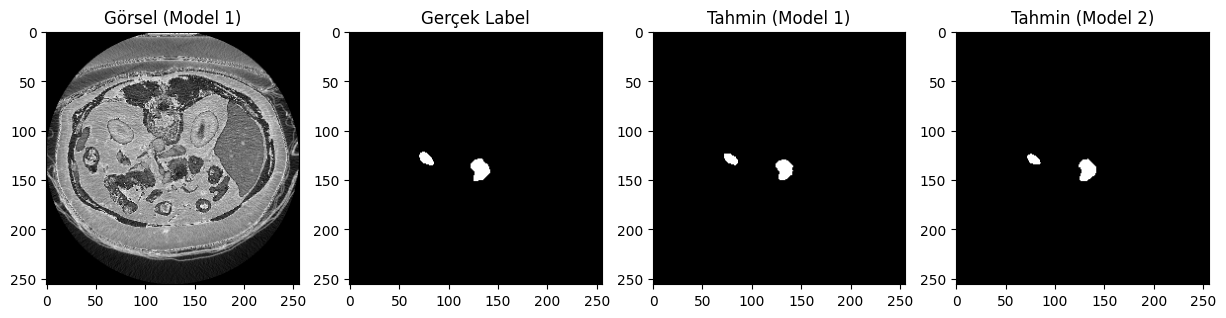

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np

# Modelleri yükleyin
model_1 = load_model('/content/drive/My Drive/4-pancreas/models/unet_pancreas_model.h5')
model_2 = load_model('/content/drive/My Drive/4-pancreas/models/unet_pancreas_model_2.h5')

# Test için örnek görseller seçin
sample_idx = np.random.randint(0, len(X_val), 3)
for i in sample_idx:
    img = X_val[i]
    lbl = Y_val[i]

    # Tahmin yapın (Model 1 ve Model 2 için)
    pred_1 = model_1.predict(img[np.newaxis, ...])[0]
    pred_1 = (pred_1 > 0.5).astype(np.uint8)  # Eşikleme

    pred_2 = model_2.predict(img[np.newaxis, ...])[0]
    pred_2 = (pred_2 > 0.5).astype(np.uint8)  # Eşikleme

    # Görüntüleri ve tahminleri görselleştir
    plt.figure(figsize=(15, 5))

    # Model 1
    plt.subplot(1, 4, 1)
    plt.title("Görsel (Model 1)")
    plt.imshow(img.squeeze(), cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title("Gerçek Label")
    plt.imshow(lbl.squeeze(), cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title("Tahmin (Model 1)")
    plt.imshow(pred_1.squeeze(), cmap='gray')

    # Model 2
    plt.subplot(1, 4, 4)
    plt.title("Tahmin (Model 2)")
    plt.imshow(pred_2.squeeze(), cmap='gray')

    plt.show()


In [ ]:
# Modeli kaydet
model.save('/content/drive/My Drive/4-pancreas/models/unet_pancreas_model_2.h5')
